In [14]:
## Link: https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
import os
import re
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import scipy.signal as scisig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import heartpy as hp
import biosppy
import time
import neurokit2 as nk
from heartpy.datautils import *
from heartpy.peakdetection import *
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

In [36]:
features_list = ['ACCx_mean', 'ACCx_std', 'ACCx_max', 'ACCx_min', 'ACCx_absint', 'ACCx_peakfreq',
                 'ACCy_mean', 'ACCy_std', 'ACCy_max', 'ACCy_min', 'ACCy_absint', 'ACCy_peakfreq',
                 'ACCz_mean', 'ACCz_std', 'ACCz_max', 'ACCz_min', 'ACCz_absint', 'ACCz_peakfreq',
                 'ACC_mean', 'ACC_std', 'ACC_max', 'ACC_min', 'ACC_absint', 'ACC_peakfreq',
                 'ECG_mean', 'ECG_std', 'ECG_max', 'ECG_min', 'ECG_bpm', 'ECG_ibi', 'ECG_sdnn', 'ECG_sdsd', 'ECG_rmssd', 'ECG_pnn20', 'ECG_pnn50',
                 'EMG_mean', 'EMG_std', 'EMG_max', 'EMG_min', 'EMG_drange', 'EMG_absint',
                 'EDA_mean', 'EDA_std', 'EDA_max', 'EDA_min', 'EDA_drange', 'EDA_slope',
                 'EDA_SCR_mean', 'EDA_SCR_std', 'EDA_SCR_max', 'EDA_SCR_min', 'EDA_SCR_drange', 'EDA_SCR_slope',
                 'EDA_SCL_mean', 'EDA_SCL_std', 'EDA_SCL_max', 'EDA_SCL_min', 'EDA_SCL_drange', 'EDA_SCL_slope',
                 'TEMP_mean', 'TEMP_std', 'TEMP_max', 'TEMP_min', 'TEMP_drange', 'TEMP_slope',
                 'RESP_mean', 'RESP_std', 'RESP_max', 'RESP_min', 'RESP_drange', 'RESP_slope',
                 
                 'ACCxW_mean', 'ACCxW_std', 'ACCxW_max', 'ACCxW_min', 'ACCxW_absint', 'ACCxW_peakfreq',
                 'ACCyW_mean', 'ACCyW_std', 'ACCyW_max', 'ACCyW_min', 'ACCyW_absint', 'ACCyW_peakfreq',
                 'ACCzW_mean', 'ACCzW_std', 'ACCzW_max', 'ACCzW_min', 'ACCzW_absint', 'ACCzW_peakfreq',
                 'ACCW_mean', 'ACCW_std', 'ACCW_max', 'ACCW_min', 'ACCW_absint', 'ACCW_peakfreq',
                 'EDAW_mean', 'EDAW_std', 'EDAW_max', 'EDAW_min', 'EDAW_drange', 'EDAW_slope',
                 'EDAW_SCR_mean', 'EDAW_SCR_std', 'EDAW_SCR_max', 'EDAW_SCR_min', 'EDAW_SCR_drange', 'EDAW_SCR_slope',
                 'EDAW_SCL_mean', 'EDAW_SCL_std', 'EDAW_SCL_max', 'EDAW_SCL_min', 'EDAW_SCL_drange', 'EDAW_SCL_slope',
                 'BVPW_mean', 'BVPW_std', 'BVPW_max', 'BVPW_min', 'BVPW_peakfreq',
                 'TEMPW_mean', 'TEMPW_std', 'TEMPW_max', 'TEMPW_min', 'TEMPW_drange', 'TEMPW_slope'
                 ]

In [37]:
class SubjectData:
    
    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        self.features_list = ['ACCx_mean', 'ACCx_std', 'ACCx_max', 'ACCx_min', 'ACCx_absint', 'ACCx_peakfreq',
                 'ACCy_mean', 'ACCy_std', 'ACCy_max', 'ACCy_min', 'ACCy_absint', 'ACCy_peakfreq',
                 'ACCz_mean', 'ACCz_std', 'ACCz_max', 'ACCz_min', 'ACCz_absint', 'ACCz_peakfreq',
                 'ACC_mean', 'ACC_std', 'ACC_max', 'ACC_min', 'ACC_absint', 'ACC_peakfreq',
                 'ECG_mean', 'ECG_std', 'ECG_max', 'ECG_min', 'ECG_bpm', 'ECG_ibi', 'ECG_sdnn', 'ECG_sdsd', 'ECG_rmssd', 'ECG_pnn20', 'ECG_pnn50',
                 'EMG_mean', 'EMG_std', 'EMG_max', 'EMG_min', 'EMG_drange', 'EMG_absint',
                 'EDA_mean', 'EDA_std', 'EDA_max', 'EDA_min', 'EDA_drange', 'EDA_slope',
                 'EDA_SCR_mean', 'EDA_SCR_std', 'EDA_SCR_max', 'EDA_SCR_min', 'EDA_SCR_drange', 'EDA_SCR_slope',
                 'EDA_SCL_mean', 'EDA_SCL_std', 'EDA_SCL_max', 'EDA_SCL_min', 'EDA_SCL_drange', 'EDA_SCL_slope',
                 'TEMP_mean', 'TEMP_std', 'TEMP_max', 'TEMP_min', 'TEMP_drange', 'TEMP_slope',
                 'RESP_mean', 'RESP_std', 'RESP_max', 'RESP_min', 'RESP_drange', 'RESP_slope',
                 
                 'ACCxW_mean', 'ACCxW_std', 'ACCxW_max', 'ACCxW_min', 'ACCxW_absint', 'ACCxW_peakfreq',
                 'ACCyW_mean', 'ACCyW_std', 'ACCyW_max', 'ACCyW_min', 'ACCyW_absint', 'ACCyW_peakfreq',
                 'ACCzW_mean', 'ACCzW_std', 'ACCzW_max', 'ACCzW_min', 'ACCzW_absint', 'ACCzW_peakfreq',
                 'ACCW_mean', 'ACCW_std', 'ACCW_max', 'ACCW_min', 'ACCW_absint', 'ACCW_peakfreq',
                 'EDAW_mean', 'EDAW_std', 'EDAW_max', 'EDAW_min', 'EDAW_drange', 'EDAW_slope',
                 'EDAW_SCR_mean', 'EDAW_SCR_std', 'EDAW_SCR_max', 'EDAW_SCR_min', 'EDAW_SCR_drange', 'EDAW_SCR_slope',
                 'EDAW_SCL_mean', 'EDAW_SCL_std', 'EDAW_SCL_max', 'EDAW_SCL_min', 'EDAW_SCL_drange', 'EDAW_SCL_slope',
                 'BVPW_mean', 'BVPW_std', 'BVPW_max', 'BVPW_min', 'BVPW_peakfreq',
                 'TEMPW_mean', 'TEMPW_std', 'TEMPW_max', 'TEMPW_min', 'TEMPW_drange', 'TEMPW_slope'
                 ]
        
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        
        self.label = data['label']
        self.ACCx = data['signal']['chest']['ACC'][:, 0]
        self.ACCy = data['signal']['chest']['ACC'][:, 1]
        self.ACCz = data['signal']['chest']['ACC'][:, 2]
        self.ACC = np.sqrt((self.ACCx ** 2 + self.ACCy ** 2 + self.ACCz ** 2))
        self.ECG = data['signal']['chest']['ECG'].squeeze(-1)
        self.EMG = data['signal']['chest']['EMG'].squeeze(-1)
        
        self.EDA = butter_lowpass_filter(data['signal']['chest']['EDA'].squeeze(-1), 1.0, 700, 6)
        eda_data = nk.eda_phasic(nk.standardize(self.EDA), sampling_rate=700)
        self.EDA_SCR = eda_data['EDA_Phasic']
        self.EDA_SCL = eda_data['EDA_Tonic']
        
        self.TEMP = data['signal']['chest']['Temp'].squeeze(-1)
        self.RESP = data['signal']['chest']['Resp'].squeeze(-1)
        
        target_len = len(self.ECG)
        self.ACCxW = interpolate(data['signal']['wrist']['ACC'][:, 0], target_len)
        self.ACCyW = interpolate(data['signal']['wrist']['ACC'][:, 1], target_len)
        self.ACCzW = interpolate(data['signal']['wrist']['ACC'][:, 2], target_len)
        self.ACCW = np.sqrt((self.ACCxW ** 2 + self.ACCyW ** 2 + self.ACCzW ** 2))
        self.BVPW = interpolate(data['signal']['wrist']['BVP'].squeeze(-1), target_len)
        
        self.EDAW = butter_lowpass_filter(interpolate(data['signal']['wrist']['EDA'].squeeze(-1), target_len), 1.0, 700, 6)
        eda_data = nk.eda_phasic(nk.standardize(self.EDAW), sampling_rate=700)
        self.EDAW_SCR = eda_data['EDA_Phasic']
        self.EDAW_SCL = eda_data['EDA_Tonic']
        
        self.TEMPW = interpolate(data['signal']['wrist']['TEMP'].squeeze(-1), target_len)
        
        self.index_baseline = np.argwhere(self.label == 1).squeeze(-1)
        self.index_stress = np.argwhere(self.label == 2).squeeze(-1)
        self.index_amusement = np.argwhere(self.label == 3).squeeze(-1)


In [2]:
import pickle
with open('data/WESAD/S2/S2.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')

In [11]:
c = data['signal']['chest']['EDA'].squeeze(-1)
w = data['signal']['wrist']['EDA'].squeeze(-1)
print(c.shape)
print(w.shape)

(4255300,)
(24316,)


In [17]:
def interpolate(data, target_length):
    return np.interp(np.linspace(0, len(data)-1, target_length), np.arange(0, len(data)), data)

In [18]:
# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

In [19]:
def get_absolute_integral(x):
    return np.sum(np.abs(x), 1)

In [20]:
def get_slope(series):
    linreg = scipy.stats.linregress(np.arange(len(series)), series )
    slope = linreg[0]
    return slope

In [21]:
def get_dynamic_range(x):
    return np.amax(x, 1) / np.amin(x, 1)

In [22]:
def sliding_window(signal, win_len, shift):

    n_windows = int((signal.shape[0] - win_len) / shift) + 1
    samples = []
    
    for i in range(n_windows):
        samples.append(signal[i * shift: i * shift + win_len])
    
    samples = np.stack(samples)
    
    return samples

In [23]:
def get_peak_freq(x):
    f, Pxx = scisig.periodogram(x, fs=700)
    psd_dict = {amp: freq for amp, freq in zip(Pxx, f)}
    peak_freq = psd_dict[max(psd_dict.keys())]
    return peak_freq

In [24]:
def extract_features_ACC(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    abs_ints = get_absolute_integral(samples)
    
    peak_freqs = np.zeros_like(means)
    for i in range(samples.shape[0]):
        peak_freqs[i] = get_peak_freq(samples[i])
        
    ACC_features = np.stack([means, stds, mins, maxs, abs_ints, peak_freqs], 1)
    
    return ACC_features

def extract_features_ECG(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    
    bpms = np.zeros_like(means)
    ibis = np.zeros_like(means)
    sdnns = np.zeros_like(means)
    sdsds = np.zeros_like(means)
    rmssds = np.zeros_like(means)
    pnn20s = np.zeros_like(means)
    pnn50s = np.zeros_like(means)
    
    for i in range(samples.shape[0]):
        wd, m = hp.process(samples[i], 700)
        bpms[i] = m['bpm']
        ibis[i] = m['ibi']
        sdnns[i] = m['sdnn']
        sdsds[i] = m['sdsd']
        rmssds[i] = m['rmssd']
        pnn20s[i] = m['pnn20']
        pnn50s[i] = m['pnn50']
        
    ECG_features = np.stack([means, stds, mins, maxs, bpms, ibis, sdnns, sdsds, rmssds, pnn20s, pnn50s], 1)
    return ECG_features

def extract_features_EMG(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    dranges = get_dynamic_range(samples)
    abs_ints = get_absolute_integral(samples)
    
    EDA_features = np.stack([means, stds, mins, maxs, dranges, abs_ints], 1)
    return EDA_features

def extract_features_EDA(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    dranges = get_dynamic_range(samples)
    
    slopes = np.zeros_like(means)
    for i in range(samples.shape[0]):
        slopes[i] = get_slope(samples[i])
    
    EDA_features = np.stack([means, stds, mins, maxs, dranges, slopes], 1)
    return EDA_features


def extract_features_TEMP(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    dranges = get_dynamic_range(samples)
    
    slopes = np.zeros_like(means)
    for i in range(samples.shape[0]):
        slopes[i] = get_slope(samples[i])
    
    TEMP_features = np.stack([means, stds, mins, maxs, dranges, slopes], 1)
    return TEMP_features

def extract_features_RESP(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    dranges = get_dynamic_range(samples)
    
    slopes = np.zeros_like(means)
    for i in range(samples.shape[0]):
        slopes[i] = get_slope(samples[i])
    
    RESP_features = np.stack([means, stds, mins, maxs, dranges, slopes], 1)
    return RESP_features


def extract_features_BVP(signal, win_len, shift):
    samples = sliding_window(signal, win_len, shift)
    means = np.mean(samples, 1)
    stds = np.std(samples, 1)
    mins = np.amin(samples, 1)
    maxs = np.amax(samples, 1)
    
    peak_freqs = np.zeros_like(means)
    for i in range(samples.shape[0]):
        peak_freqs[i] = get_peak_freq(samples[i])
        
    BVP_features = np.stack([means, stds, mins, maxs, peak_freqs], 1)
    
    return BVP_features

In [26]:
def extract_features(subject, label, win_len, shift):
    if label == 'baseline':
        index = subject.index_baseline
    if label == 'stress':
        index = subject.index_stress
    if label == 'amusement':
        index = subject.index_amusement

    ACCx_features = extract_features_ACC(subject.ACCx[index], win_len, shift)
    ACCy_features = extract_features_ACC(subject.ACCy[index], win_len, shift)
    ACCz_features = extract_features_ACC(subject.ACCz[index], win_len, shift)
    ACC_features = extract_features_ACC(subject.ACC[index], win_len, shift)
    ECG_features = extract_features_ECG(subject.ECG[index], win_len, shift)
    EMG_features = extract_features_EMG(subject.EMG[index], win_len, shift)
    EDA_features = extract_features_EDA(subject.EDA[index], win_len, shift)
    EDA_SCR_features = extract_features_EDA(subject.EDA_SCR[index], win_len, shift)
    EDA_SCL_features = extract_features_EDA(subject.EDA_SCL[index], win_len, shift)
    TEMP_features = extract_features_TEMP(subject.TEMP[index], win_len, shift)
    RESP_features = extract_features_RESP(subject.RESP[index], win_len, shift)
    
    ACCxW_features = extract_features_ACC(subject.ACCxW[index], win_len, shift)
    ACCyW_features = extract_features_ACC(subject.ACCyW[index], win_len, shift)
    ACCzW_features = extract_features_ACC(subject.ACCzW[index], win_len, shift)
    ACCW_features = extract_features_ACC(subject.ACCW[index], win_len, shift)
    EDAW_features = extract_features_EDA(subject.EDAW[index], win_len, shift)
    EDAW_SCR_features = extract_features_EDA(subject.EDAW_SCR[index], win_len, shift)
    EDAW_SCL_features = extract_features_EDA(subject.EDAW_SCL[index], win_len, shift)
    BVPW_features = extract_features_BVP(subject.BVPW[index], win_len, shift)
    TEMPW_features = extract_features_TEMP(subject.TEMPW[index], win_len, shift)
    
    
    features = np.concatenate([ACCx_features, ACCy_features, ACCz_features, ECG_features, EMG_features,
                               EMG_features, EDA_features, EDA_SCR_features, EDA_SCL_features, TEMP_features, RESP_features,
                               ACCxW_features, ACCyW_features, ACCzW_features, ACCW_features, EDAW_features, EDAW_SCR_features,
                               EDAW_SCL_features, BVPW_features, TEMPW_features], 1)
    
    return features

In [28]:
def make_patient_data(subject_id, win_len, shift):
    subject = SubjectData(main_path='data/WESAD', subject_number=subject_id)
    baseline_features = extract_features(subject, 'baseline', win_len, shift)
    stress_features = extract_features(subject, 'stress', win_len, shift)
    amusement_features = extract_features(subject, 'amusement', win_len, shift)
    X = np.concatenate([baseline_features, stress_features, amusement_features])
    
    baseline_labels = np.full(len(baseline_features), 1)
    stress_labels = np.full(len(stress_features), 2)
    amusement_labels = np.full(len(amusement_features), 3)
    
    Y = np.concatenate([baseline_labels, stress_labels, amusement_labels])
    
    return X, Y

In [29]:
def make_dataset(subject_ids, win_len, shift):
    Xs = []
    Ys = []
    
    for subject_id in subject_ids:
        X, Y = make_patient_data(subject_id, win_len, shift)
        Xs.append(X)
        Ys.append(Y)
    
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    
    return Xs, Ys

In [60]:
def experiment(train_ids, test_ids, win_len, shift):
    
    start_time = time.time()
    #X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.2, random_state=0)  
    X_train, y_train = make_dataset(train_ids, win_len=win_len, shift=shift)
    X_test, y_test = make_dataset(test_ids, win_len=win_len, shift=shift)
    print("--- %s seconds ---" % (time.time() - start_time))

    classifier = RandomForestClassifier(max_depth=4, random_state=0)
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test) 
    
    cm = confusion_matrix(y_test, y_pred)  
    print(cm)  
    print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))  
    rf_baseline_acc = accuracy_score(y_test, y_pred)

    importances = classifier.feature_importances_
    forest_importances = pd.Series(importances, index=features_list).sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances[:20].plot.barh(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    

--- 116.53205704689026 seconds ---
[[117   0   0]
 [  2  65   1]
 [ 13   0  23]]
Accuracy: 0.9276018099547512


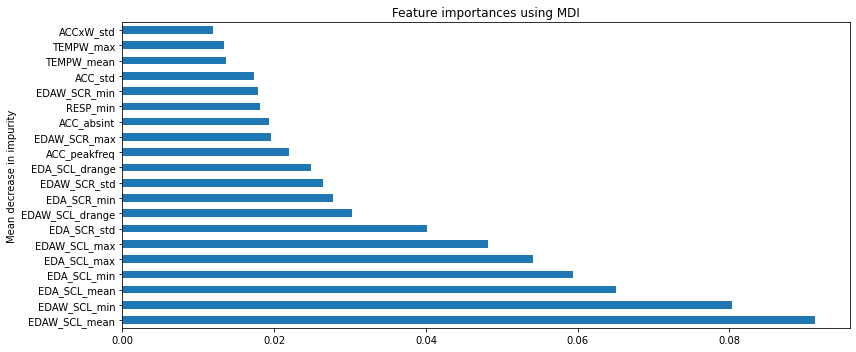

In [61]:
train_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]
test_ids = [15, 16, 17]
experiment(train_ids, test_ids, 21000, 21000)